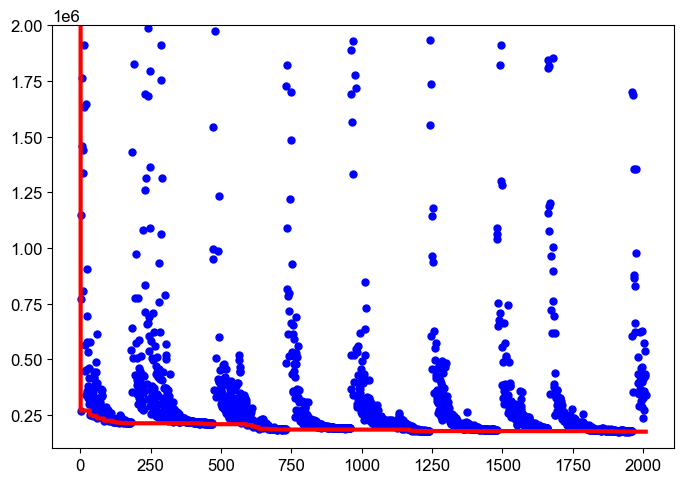

In [1]:
from solair.constants import constants
from solair.simulation import DynamicLength
from solair.cost import calculate_total_cost_air_cooler, calculate_sub_cost_air_cooler
from solair.design import Tube
from optimization import CSP
import numpy as np
from matplotlib import pyplot as plt
import os

plt.rc('font', family='Arial', size=12)

# load previuos fit
X, fX = np.load("outputs/output.npz").values()

# PLOT 
fig = plt.figure(figsize=(7, 5))
plt.plot(fX, 'b.', ms=10)  # Plot all evaluated points as blue dots
plt.plot(np.minimum.accumulate(fX), 'r', lw=3)  # Plot cumulative minimum as a red line
plt.ylim([1e5, 2e6])
plt.tight_layout()
os.makedirs("plots", exist_ok=True)
plt.savefig("plots/optimization.pdf", dpi=300)

 # Checking price after optimization

In [2]:
csp = CSP()
def get_cost(x):
    cost, tube_cost, fan_cost, tube = csp._run_simulation(x)
    return cost, tube

x_best = X[fX.argmin()]
cost_best, tube_best = get_cost(x_best)
print("x_best", x_best)
print(cost_best)


x_best [1.00872716e-02 1.10333865e+00 1.25429588e+00 1.10120115e+00
 1.67538497e+00 1.03853554e-03 1.00387079e-01 2.99414467e+01]
174592.8259266301


 # Checking original price tag

In [3]:
# default configuration from reference paper
tube_in_diameter: float = 20e-3
tube_out_diameter: float = 25e-3
fin_in_diameter: float = 28e-3
fin_out_diameter: float = 57e-3
tube_transverse_pitch: float = 58e-3
fin_pitch: float = 2.8e-3
fin_thickness: float = 7.5e-4
t_air_out: float = x_best[-1] # 20

# We ned to recompute things in the form the optimizer expects
x_origin = np.array([tube_in_diameter, tube_out_diameter/ tube_in_diameter, fin_in_diameter/ tube_out_diameter, fin_out_diameter/ fin_in_diameter, tube_transverse_pitch/fin_out_diameter,
                      fin_pitch, fin_thickness/ fin_pitch, t_air_out])
cost_orig, tube_orig = get_cost(x_origin)
print(cost_orig)

729041.4558953414


In [4]:
# default configuration from reference paper
tube_out_diameter: float = 25e-3
tube_in_diameter: float = 20e-3
fin_out_diameter: float = 57e-3
fin_in_diameter: float = 28e-3
tube_transverse_pitch: float = 58e-3
fin_pitch: float = 2.8e-3
fin_thickness: float = 7.5e-4
t_air_out: float = x_best[-1] # 20
# We ned to recompute things in the form the optimizer expects
x_origin = np.array([tube_in_diameter, tube_out_diameter/ tube_in_diameter, fin_in_diameter/ tube_out_diameter, fin_out_diameter/ fin_in_diameter, tube_transverse_pitch/fin_out_diameter,
                      fin_pitch, fin_thickness/ fin_pitch, t_air_out])
cost_orig, tube_orig = get_cost(x_origin)
print(cost_orig)

729041.4558953414


In [5]:
costs = []
n_segments = []
x_origin_ = x_origin[:-1]
for i in range(len(x_origin_)):
    x_temp = x_origin.copy()
    x_temp[i] = x_best[i]
    cost, tube = get_cost(x_temp)
    n_segments.append(tube.n_segments)
    costs.append(cost)

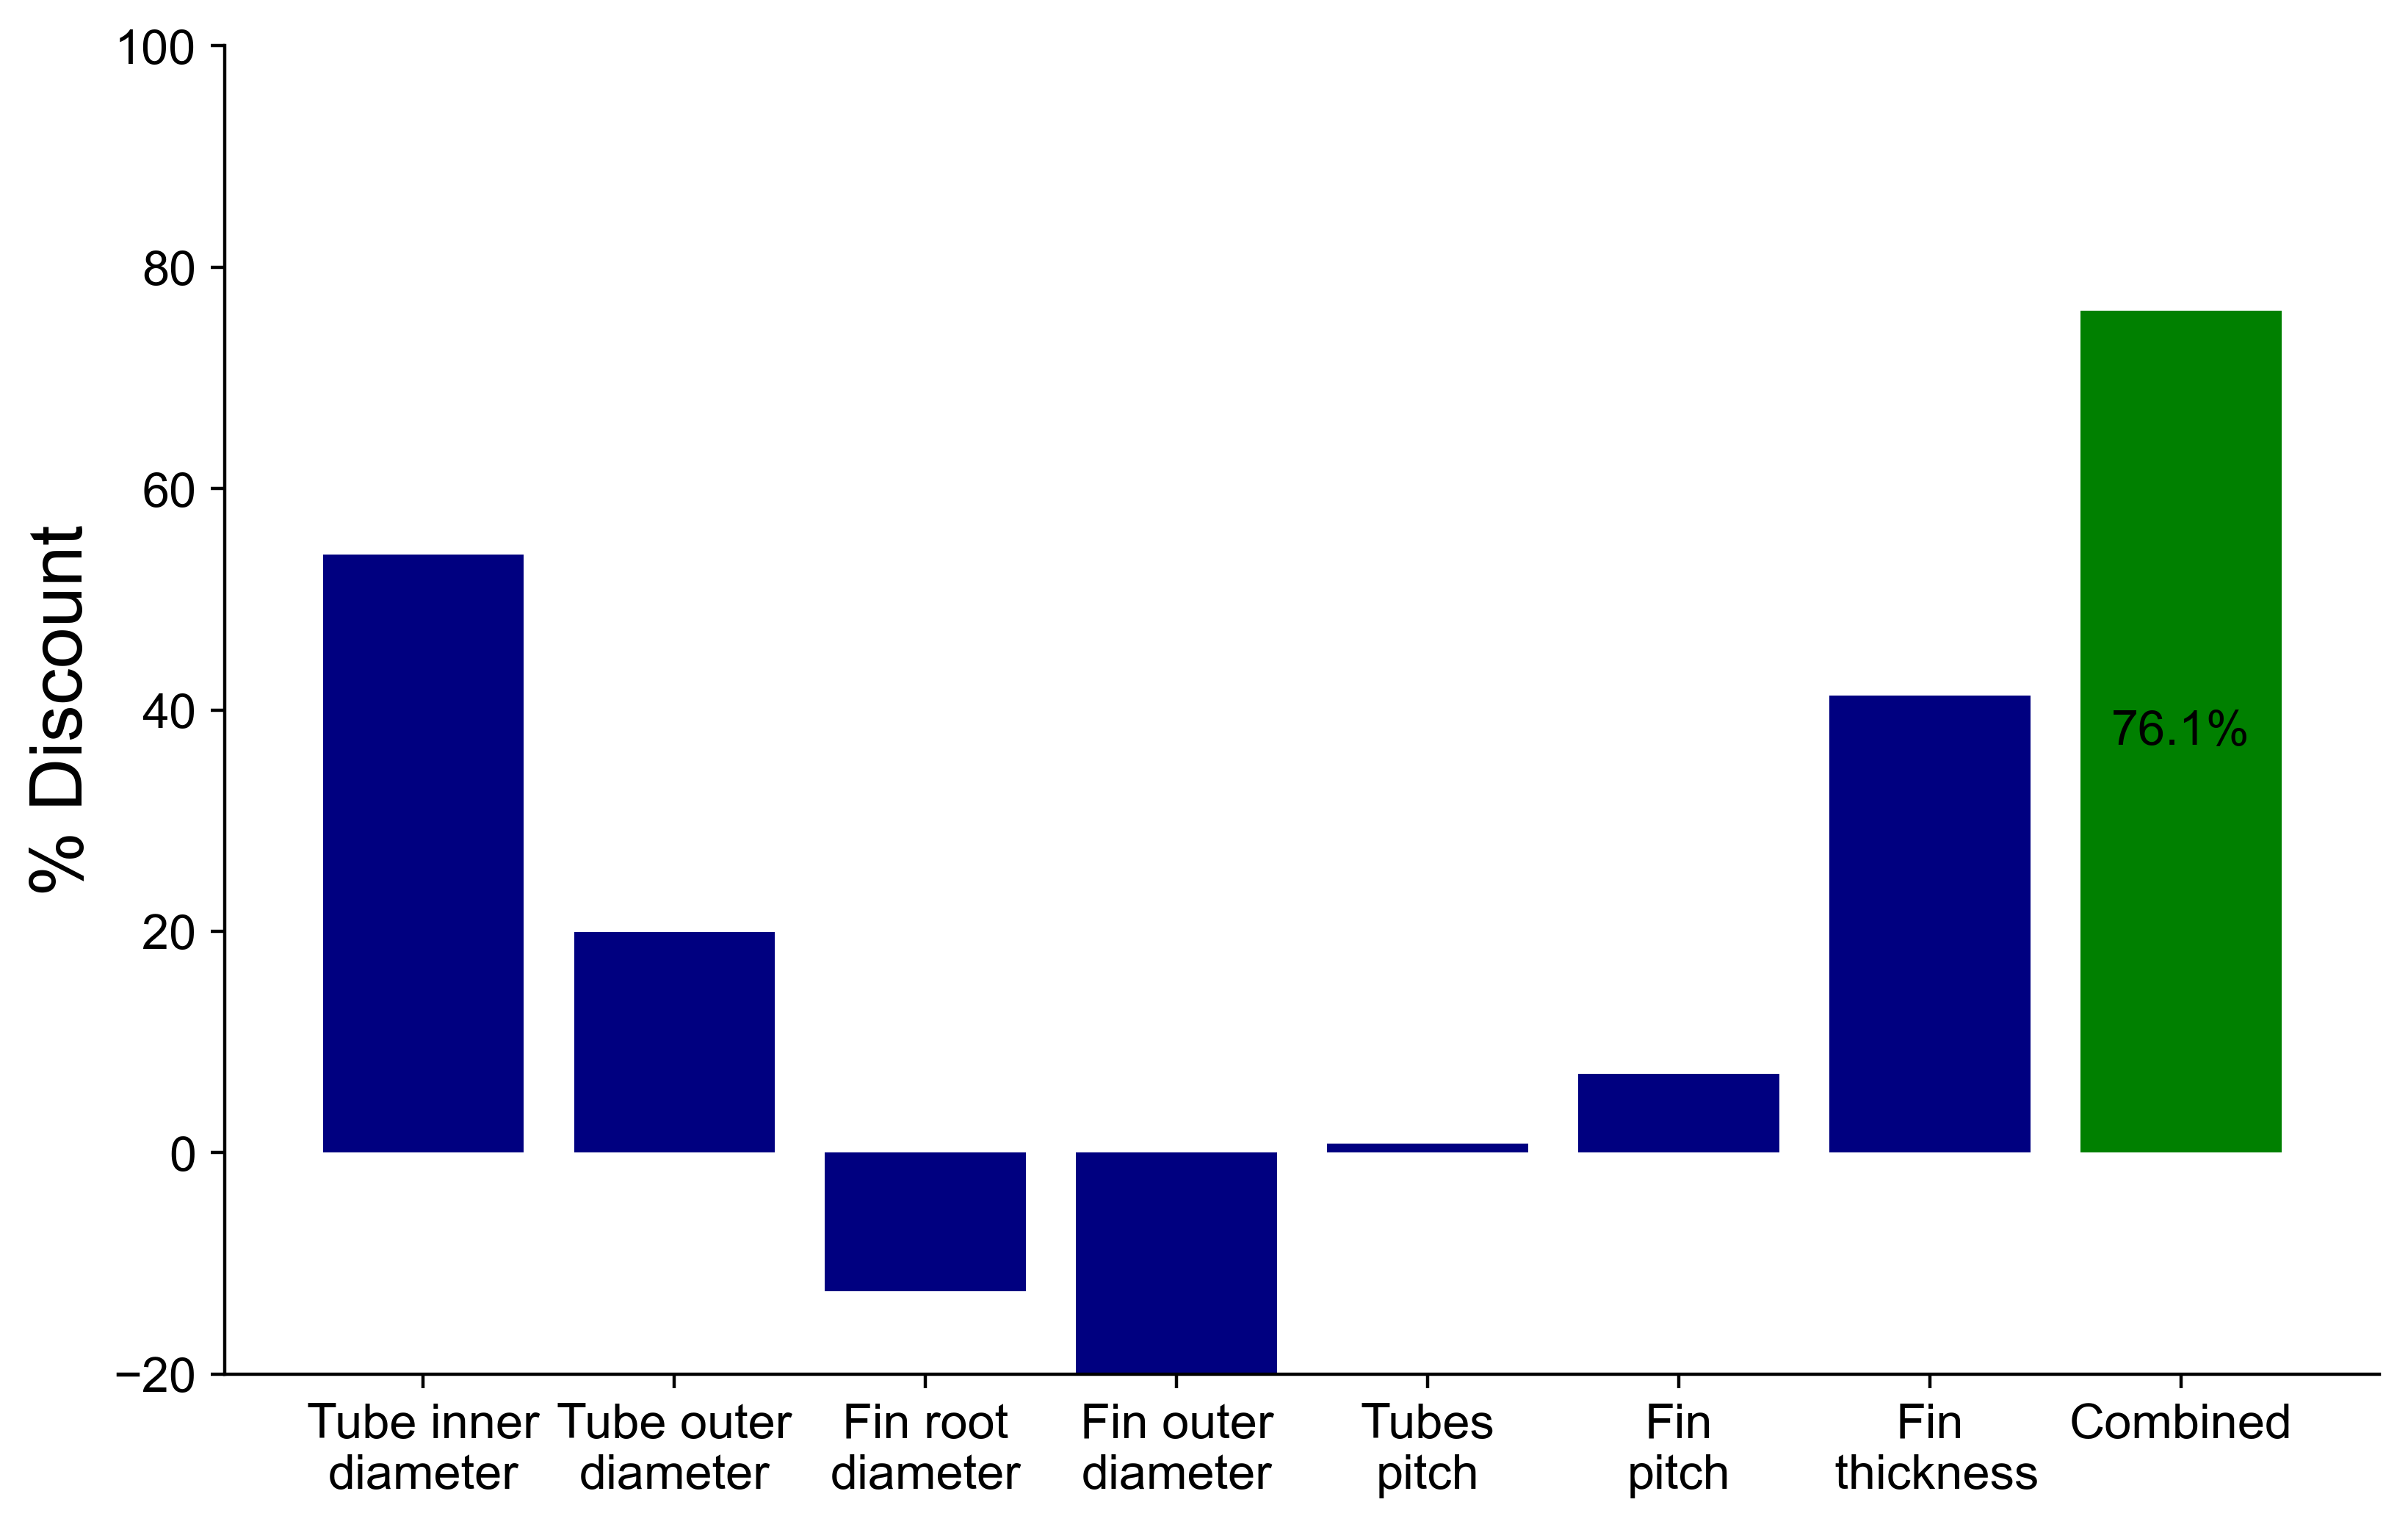

In [6]:
def savings(costs):
    return (cost_orig - np.array(costs))/ cost_orig * 100
fig, ax = plt.subplots(figsize=(8, 5), dpi=400)
plt.bar(range(len(x_origin_)), savings(costs), color="navy")
plt.bar(len(x_origin_), savings(fX.min()), color="green")
plt.xticks(range(len(x_origin_)+1), ["Tube inner\ndiameter", "Tube outer\ndiameter", "Fin root\ndiameter", "Fin outer\ndiameter",
"Tubes\npitch", "Fin\npitch", "Fin\n thickness", "Combined"])
plt.ylabel("% Discount", fontsize=18)
ax.text(len(x_origin_), savings(fX.min())/2, "{:.1f}%".format(savings(fX.min())), fontsize=12, ha='center', va='center')
plt.ylim([-20, 100])
# remove axes borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.patch.set_alpha(0.0)
fig.tight_layout(pad=0)
plt.savefig("plots/savings.pdf")

# Parameter change percentage between original and optimal design

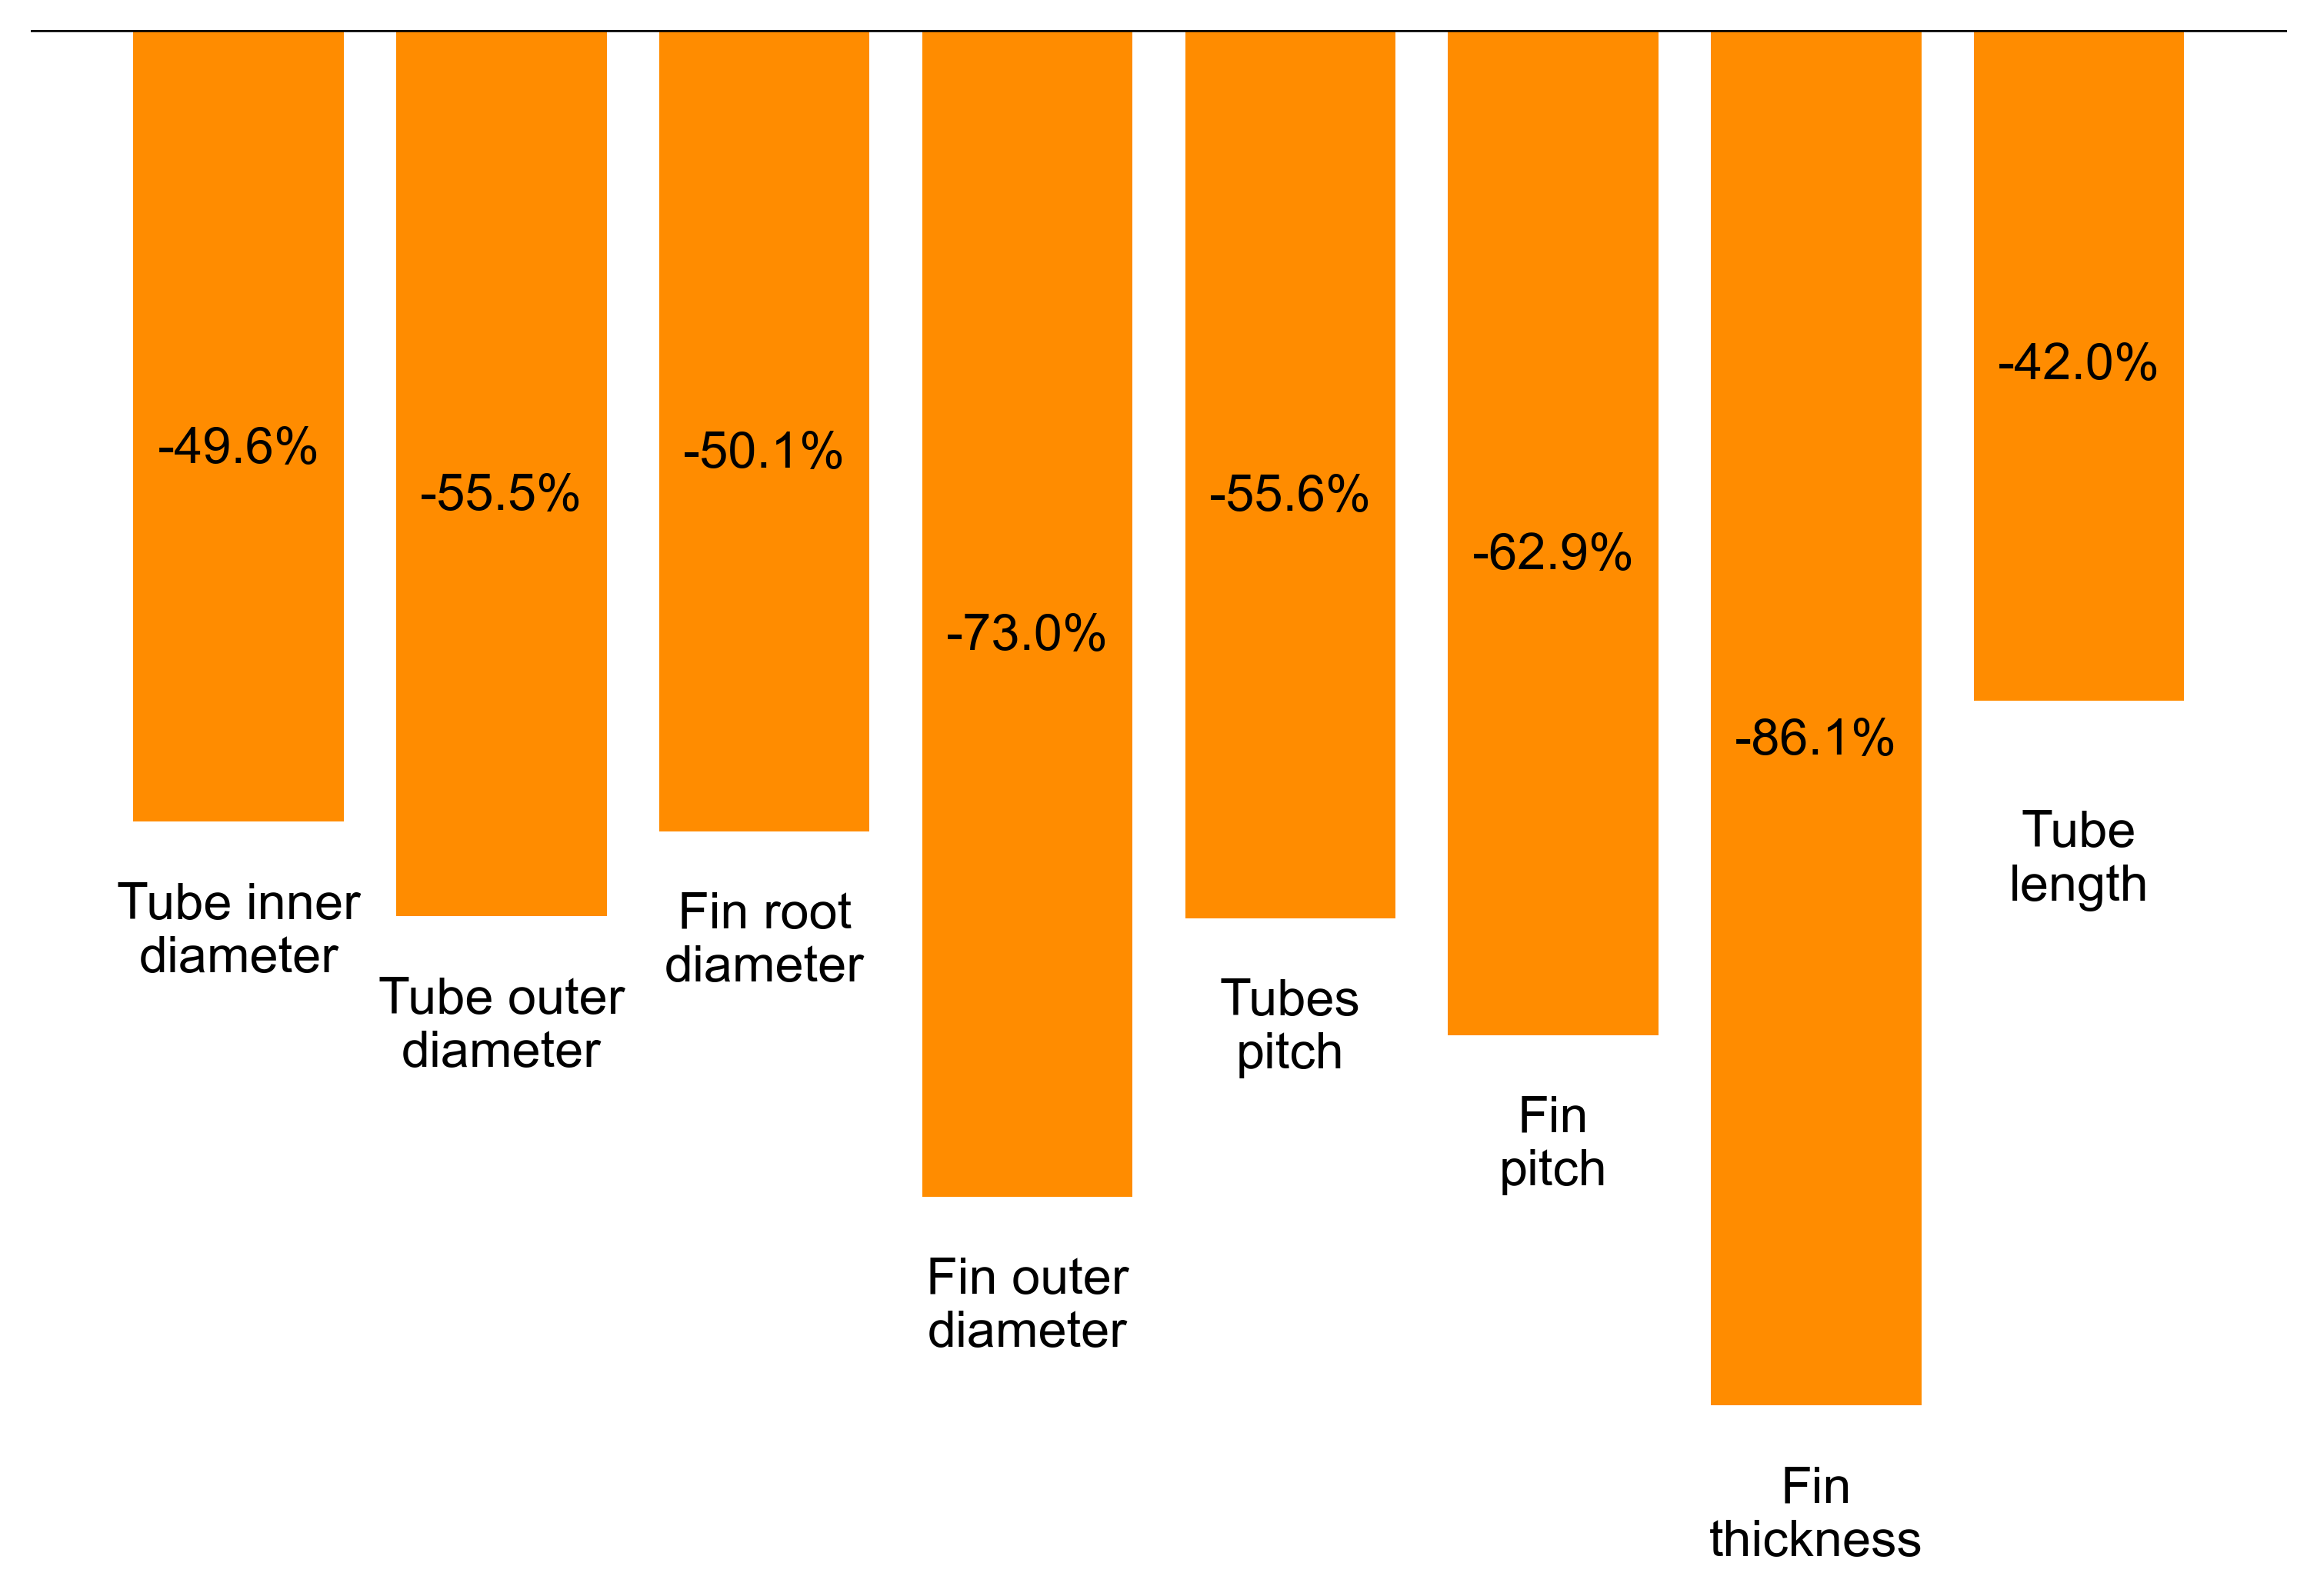

In [7]:
def get_diffs(x):
    # need to recompute things because optimizer expects different format
    # number 5 -> fin pitch is not defined in terms of other things which is
    # why we hard code 5 below

    x_origin_ = x_origin[:-1] # remove last element which is t_air_out
    x_ = x[:-1]
    diffs0 = (x_[:5].cumprod() - x_origin_[:5].cumprod())/ x_origin_[:5].cumprod() * 100 
    diffs1 = (x_[5:].cumprod() - x_origin_[5:].cumprod())/ x_origin_[5:].cumprod() * 100
    return np.concatenate((diffs0, diffs1))
num_params = len(x_origin)-1 # remove last element which is t_air_out
fig, ax = plt.subplots(figsize=(8, 5), dpi=400)

plt.bar(range(num_params), get_diffs(x_best), color="darkorange")
 # set text on top of bar
labels = ["Tube inner\ndiameter", "Tube outer\ndiameter", "Fin root\ndiameter", "Fin outer\ndiameter", 
          "Tubes\npitch", "Fin\npitch", "Fin\nthickness"]
for i, label in enumerate(labels):
    ax.text(i, get_diffs(x_best)[i] - 10, label, fontsize=12, ha='center', va='bottom')
    ax.text(i, get_diffs(x_best)[i]/2, "{:.1f}%".format(get_diffs(x_best)[i]), fontsize=12, ha='center', va='top')


tube_len_diff = (tube_best.n_segments - tube_orig.n_segments)/tube_orig.n_segments * 100 
plt.bar(num_params, tube_len_diff, color="darkorange") # add tube length
ax.text(num_params, tube_len_diff - 10, "Tube\nlength", fontsize=12, ha='center', va='center')
ax.text(num_params, tube_len_diff/2, "{:.1f}%".format((tube_best.n_segments - tube_orig.n_segments)/tube_orig.n_segments * 100), fontsize=12, ha='center', va='center')

plt.ylabel("% channge", fontsize=18)
fig.tight_layout(pad=0)
ax.set_axis_off()
ax.patch.set_alpha(0.0)
plt.axhline(0, color="black", lw=1)
plt.savefig("plots/changes.pdf")

In [8]:
def get_sim(x):
    tube_in_diameter = x[0]
    tube_out_diameter = tube_in_diameter * x[1]
    fin_in_diameter = tube_out_diameter  * x[2]
    fin_out_diameter = fin_in_diameter * x[3]
    fin_pitch = x[4]
    fin_thickness = fin_pitch * x[5]

    tube = Tube(
    tube_in_diameter=tube_in_diameter,
    tube_out_diameter=tube_out_diameter,
    fin_in_diameter=fin_in_diameter,
    fin_out_diameter=fin_out_diameter,
    fin_pitch=fin_pitch,
    fin_thickness=fin_thickness,
    )
    sim = DynamicLength(tube, verbose=0, n_sub_shx=1)
    sim.run()
    tube.n_segments = sim.n_segments
    return sim
sim_best = get_sim(x_best)
sim_origin = get_sim(x_origin)

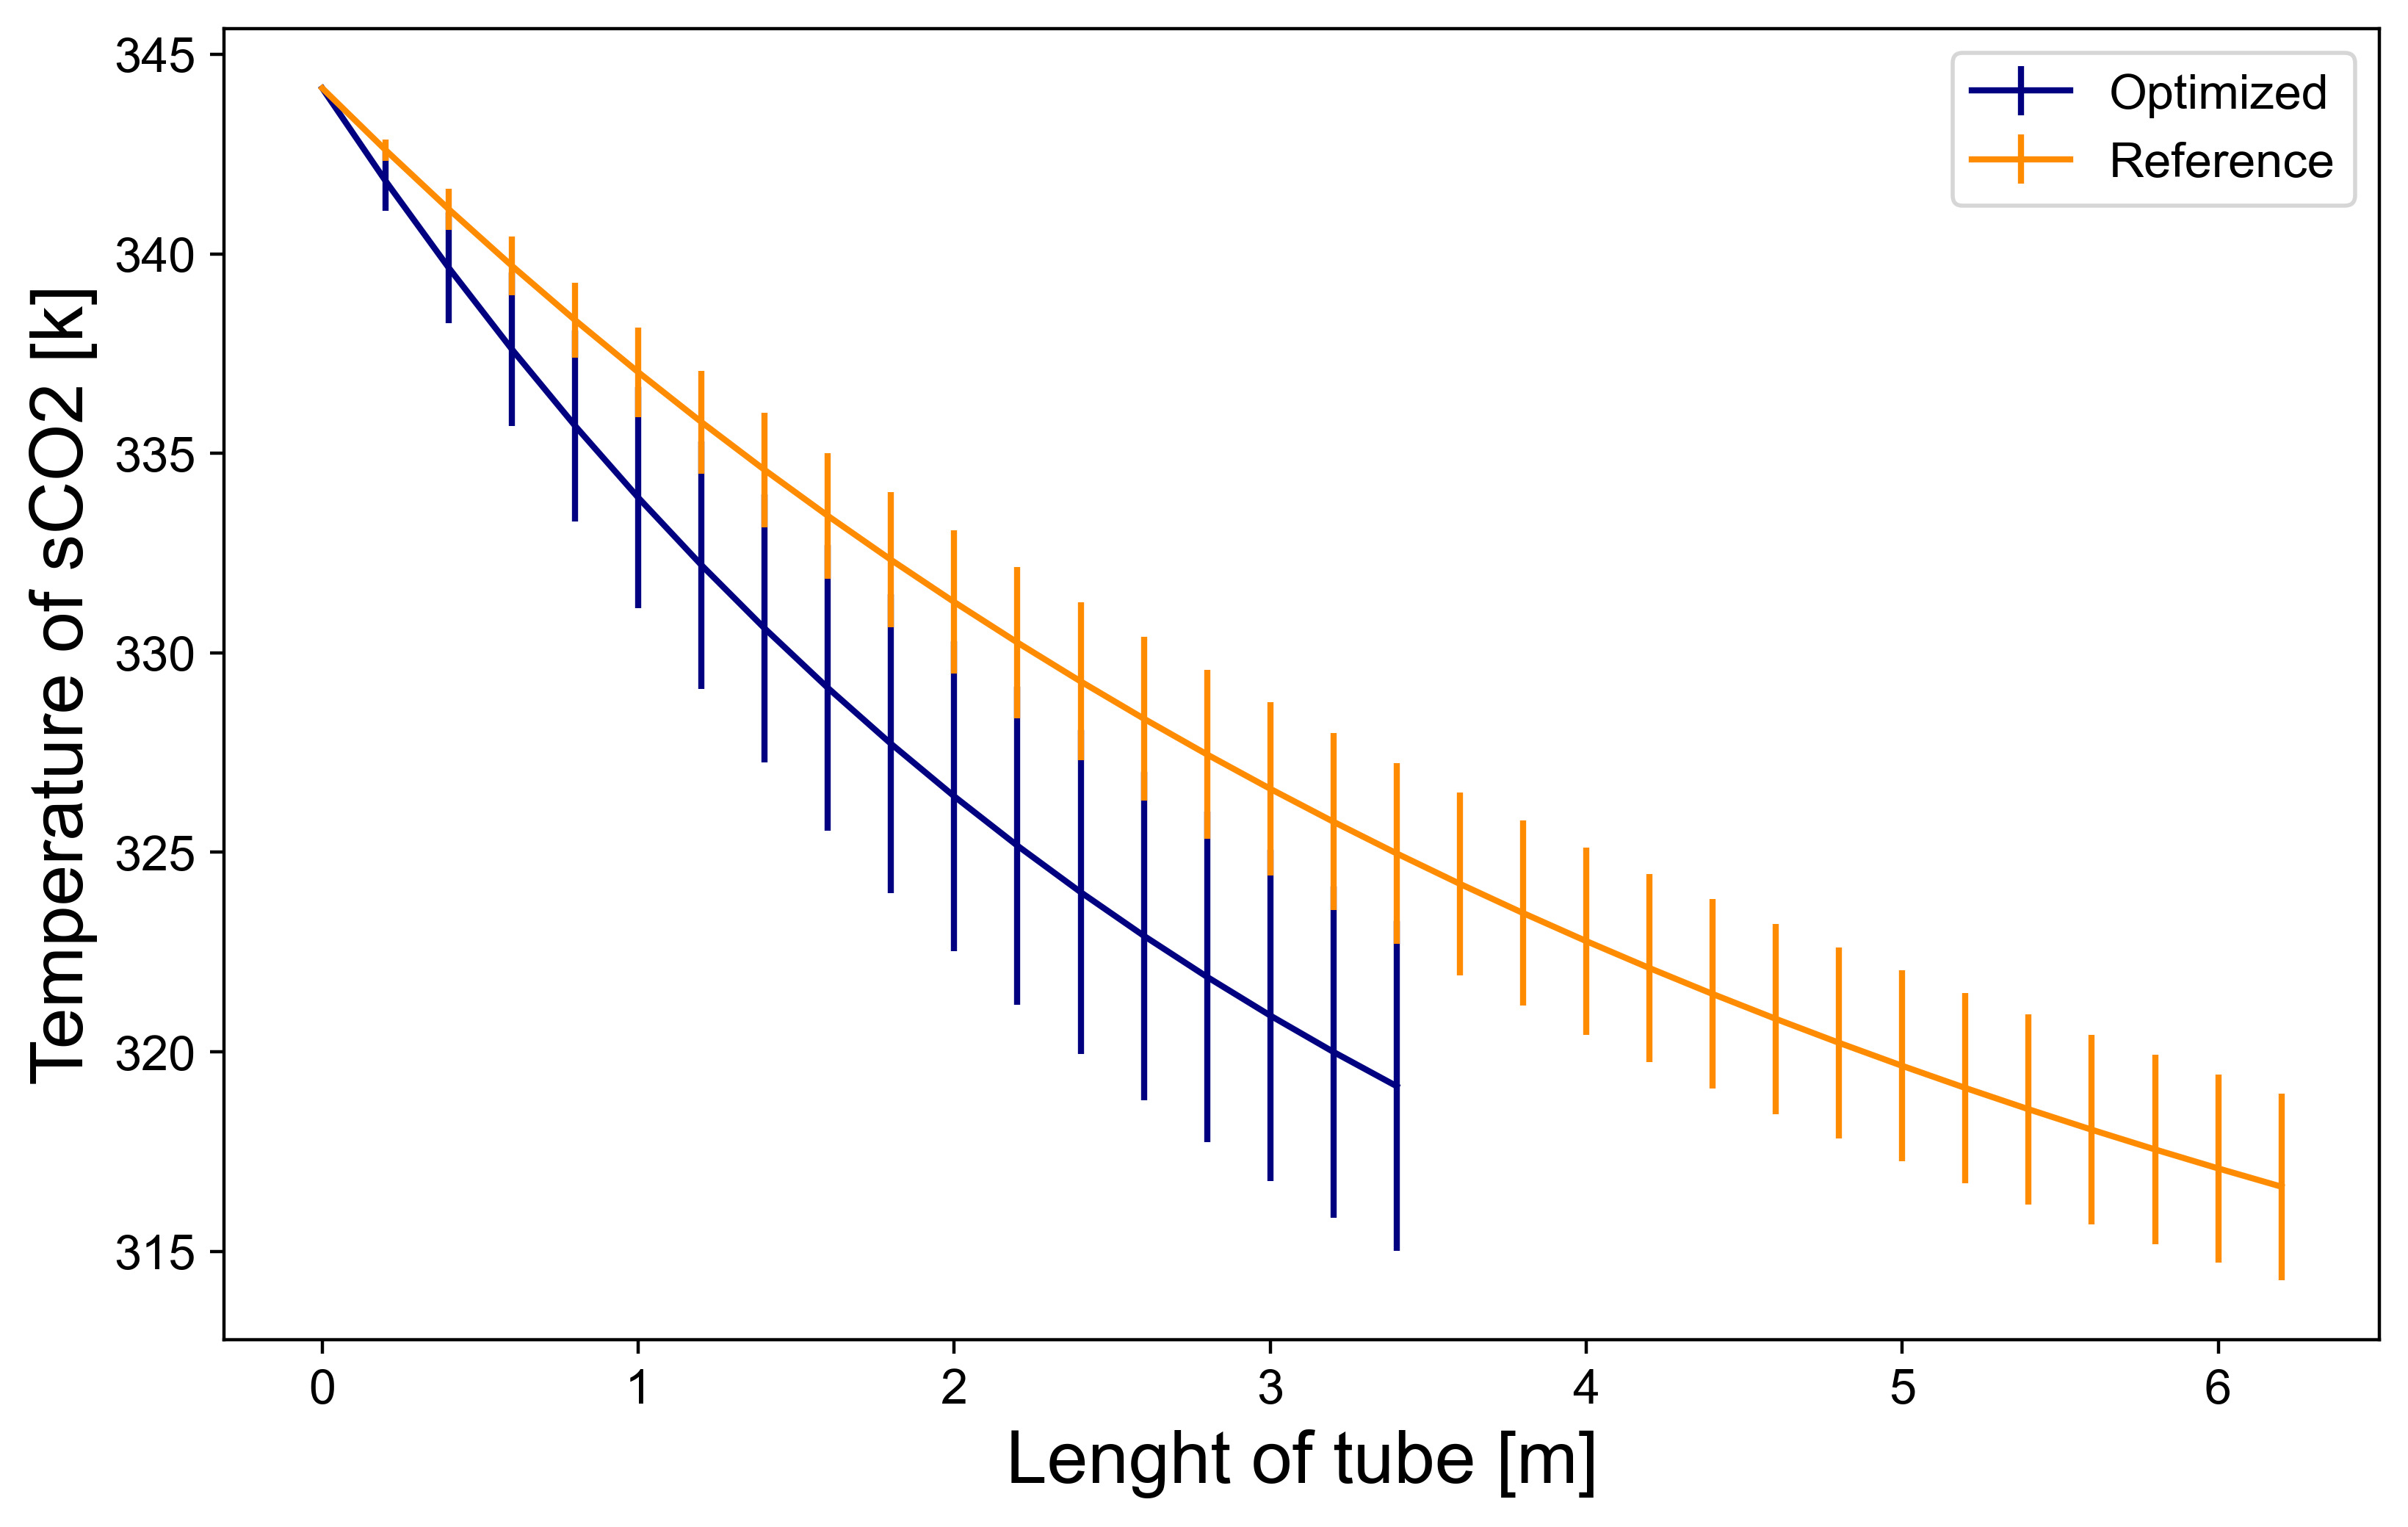

In [9]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=400)
means_best = np.mean(sim_best.results["t_co2"], axis=0)
means_origin = np.mean(sim_origin.results["t_co2"], axis=0)
stds_best = np.std(sim_best.results["t_co2"], axis=0)
stds_origin = np.std(sim_origin.results["t_co2"], axis=0)
plt.errorbar(np.linspace(0, sim_best.n_segments * tube_best.segment_length, len(means_best)), means_best, stds_best, color="navy", label="Optimized")
plt.errorbar(np.linspace(0, sim_origin.n_segments * tube_best.segment_length, len(means_origin)), means_origin, stds_origin, color="darkorange", label="Reference")
plt.legend()
plt.xlabel("Lenght of tube [m]", fontsize=18)
plt.ylabel("Temperature of sCO2 [k]", fontsize=18)
plt.tight_layout(pad=0)
ax.patch.set_alpha(0.0)
plt.savefig("plots/sim.pdf")